In [17]:
import numpy as np
import time
import tensorflow as tf
from tensornetwork.tn_keras.layers import DenseDecomp, DenseMPO
from tf_lassonet.model import LassoNet
from tf_lassonet.path import LassoPath, compute_feature_importances
from tf_lassonet.graphics import plot_history
from tf_lassonet.tensor_layer import TNLayer

In [18]:
extra_feat = 3
lam = 7.0
epochs = 400

M = 1.0

In [19]:
# Create simple model

Dense = tf.keras.layers.Dense
fc_model = tf.keras.Sequential(
    [
     tf.keras.Input(shape=(2 + extra_feat,)),
     Dense(1024, activation=tf.nn.relu),
     Dense(1024, activation=tf.nn.relu),
     Dense(1, activation=None)])
fc_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 1024)              6144      
                                                                 
 dense_10 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_11 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 1,056,769
Trainable params: 1,056,769
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Create tensorized model

tn_model = tf.keras.Sequential(
    [
     tf.keras.Input(shape=(2+extra_feat,)),
     Dense(1024, activation=tf.nn.relu),
     DenseMPO(1024, num_nodes=5, bond_dim=2, activation=tf.nn.relu),
     #DenseDecomp(1024, decomp_size = 64, activation=tf.nn.relu),
     Dense(1, activation=None)])
tn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1024)              6144      
                                                                 
 dense_mpo_1 (DenseMPO)      (None, 1024)              1280      
                                                                 
 dense_13 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 8,449
Trainable params: 8,449
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Create tensorized model with dense decomposition

tn2_model = tf.keras.Sequential(
    [
     tf.keras.Input(shape=(2+extra_feat,)),
     Dense(1024, activation=tf.nn.relu),
     #DenseMPO(1024, num_nodes=5, bond_dim=2, activation=tf.nn.relu),
     DenseDecomp(1024, decomp_size = 64, activation=tf.nn.relu),
     Dense(1, activation=None)])
tn2_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 1024)              6144      
                                                                 
 dense_decomp (DenseDecomp)  (None, 1024)              132096    
                                                                 
 dense_19 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 139,265
Trainable params: 139,265
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Create dataset

# Generate data
X_co = np.concatenate([np.random.randn(20, 2) + np.array([3, 3]),
                    np.random.randn(20, 2) + np.array([-3, -3]),
                    np.random.randn(20, 2) + np.array([-3, 3]),
                    np.random.randn(20, 2) + np.array([3, -3])]).astype('float32')
X_err = np.random.normal(0, 1.0, (80, extra_feat)).astype('float32')
X = np.concatenate((X_co, X_err), axis = 1)
Y = np.concatenate([np.ones((40)), np.zeros((40))]).astype('float32')

X_t = tf.constant(X)
y_t = tf.reshape(tf.constant(Y),(-1,1))

X_co = np.concatenate([np.random.randn(5, 2) + np.array([3, 3]),
                    np.random.randn(5, 2) + np.array([-3, -3]),
                    np.random.randn(5, 2) + np.array([-3, 3]),
                    np.random.randn(5, 2) + np.array([3, -3])]).astype('float32')
X_err = np.random.normal(0, 1.0, (20, extra_feat)).astype('float32')
Y = np.concatenate([np.ones((10)), np.zeros((10))]).astype('float32')
X = np.concatenate((X_co, X_err), axis = 1)
X_test = tf.constant(X)
y_test = tf.reshape(tf.constant(Y),(-1,1))

In [22]:
mod = LassoNet(fc_model, M = M, lambda_ = lam)

In [23]:
mod_tn = LassoNet(tn_model, M = M, lambda_ = lam)

In [35]:
mod_tn2 = LassoNet(tn2_model, M = M, lambda_ = lam)

In [24]:
mod.compile(optimizer="adam", loss="mean_squared_error", metrics = ['mean_squared_error'])
mod(tf.ones((1,2+extra_feat)))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.0637336]], dtype=float32)>

In [25]:
mod_tn.compile(optimizer="adam", loss="mean_squared_error", metrics = ['mean_squared_error'])
mod_tn(tf.ones((1,2+extra_feat)))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.22976081]], dtype=float32)>

In [36]:
mod_tn2.compile(optimizer="adam", loss="mean_squared_error", metrics = ['mean_squared_error'])
mod_tn(tf.ones((1,2+extra_feat)))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.17408498]], dtype=float32)>

In [26]:
t0 = time.time()
mod.fit(X_t, y_t, validation_data = (X_test, y_test), epochs=epochs, verbose=True)
t_fc = time.time() - t0

Epoch 1/400
3/3 [==============================] - 0s 49ms/step - loss: 12.8861 - mean_squared_error: 12.8861 - regularization: 3.4539 - number_of_features: 5.0000 - val_loss: 1.0570 - val_mean_squared_error: 1.0570
Epoch 2/400
3/3 [==============================] - 0s 12ms/step - loss: 1.7114 - mean_squared_error: 1.7114 - regularization: 3.3844 - number_of_features: 5.0000 - val_loss: 2.4400 - val_mean_squared_error: 2.4400
Epoch 3/400
3/3 [==============================] - 0s 13ms/step - loss: 2.4541 - mean_squared_error: 2.4541 - regularization: 3.3178 - number_of_features: 5.0000 - val_loss: 0.8502 - val_mean_squared_error: 0.8502
Epoch 4/400
3/3 [==============================] - 0s 13ms/step - loss: 1.0629 - mean_squared_error: 1.0629 - regularization: 3.2518 - number_of_features: 5.0000 - val_loss: 1.4252 - val_mean_squared_error: 1.4252
Epoch 5/400
3/3 [==============================] - 0s 12ms/step - loss: 1.1957 - mean_squared_error: 1.1957 - regularization: 3.1848 - number_

3/3 [==============================] - 0s 12ms/step - loss: 0.0208 - mean_squared_error: 0.0208 - regularization: 1.5855 - number_of_features: 5.0000 - val_loss: 0.0312 - val_mean_squared_error: 0.0312
Epoch 40/400
3/3 [==============================] - 0s 12ms/step - loss: 0.0213 - mean_squared_error: 0.0213 - regularization: 1.5523 - number_of_features: 5.0000 - val_loss: 0.0280 - val_mean_squared_error: 0.0280
Epoch 41/400
3/3 [==============================] - 0s 11ms/step - loss: 0.0185 - mean_squared_error: 0.0185 - regularization: 1.5220 - number_of_features: 5.0000 - val_loss: 0.0244 - val_mean_squared_error: 0.0244
Epoch 42/400
3/3 [==============================] - 0s 10ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - regularization: 1.4920 - number_of_features: 5.0000 - val_loss: 0.0220 - val_mean_squared_error: 0.0220
Epoch 43/400
3/3 [==============================] - 0s 11ms/step - loss: 0.0178 - mean_squared_error: 0.0178 - regularization: 1.4634 - number_of_feature

3/3 [==============================] - 0s 10ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - regularization: 0.7065 - number_of_features: 4.0000 - val_loss: 0.0171 - val_mean_squared_error: 0.0171
Epoch 78/400
3/3 [==============================] - 0s 12ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - regularization: 0.6882 - number_of_features: 4.0000 - val_loss: 0.0143 - val_mean_squared_error: 0.0143
Epoch 79/400
3/3 [==============================] - 0s 10ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - regularization: 0.6700 - number_of_features: 4.0000 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 80/400
3/3 [==============================] - 0s 10ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - regularization: 0.6522 - number_of_features: 4.0000 - val_loss: 0.0145 - val_mean_squared_error: 0.0145
Epoch 81/400
3/3 [==============================] - 0s 13ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - regularization: 0.6347 - number_of_feature

3/3 [==============================] - 0s 12ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - regularization: 0.2170 - number_of_features: 2.0000 - val_loss: 0.0193 - val_mean_squared_error: 0.0193
Epoch 116/400
3/3 [==============================] - 0s 12ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - regularization: 0.2113 - number_of_features: 2.0000 - val_loss: 0.0195 - val_mean_squared_error: 0.0195
Epoch 117/400
3/3 [==============================] - 0s 10ms/step - loss: 0.0145 - mean_squared_error: 0.0145 - regularization: 0.2056 - number_of_features: 2.0000 - val_loss: 0.0200 - val_mean_squared_error: 0.0200
Epoch 118/400
3/3 [==============================] - 0s 14ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - regularization: 0.2000 - number_of_features: 2.0000 - val_loss: 0.0208 - val_mean_squared_error: 0.0208
Epoch 119/400
3/3 [==============================] - 0s 10ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - regularization: 0.1946 - number_of_fea

Epoch 153/400
3/3 [==============================] - 0s 11ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - regularization: 0.0538 - number_of_features: 2.0000 - val_loss: 0.0333 - val_mean_squared_error: 0.0333
Epoch 154/400
3/3 [==============================] - 0s 11ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - regularization: 0.0506 - number_of_features: 2.0000 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 155/400
3/3 [==============================] - 0s 11ms/step - loss: 0.0217 - mean_squared_error: 0.0217 - regularization: 0.0476 - number_of_features: 2.0000 - val_loss: 0.0367 - val_mean_squared_error: 0.0367
Epoch 156/400
3/3 [==============================] - 0s 10ms/step - loss: 0.0221 - mean_squared_error: 0.0221 - regularization: 0.0445 - number_of_features: 2.0000 - val_loss: 0.0382 - val_mean_squared_error: 0.0382
Epoch 157/400
3/3 [==============================] - 0s 10ms/step - loss: 0.0237 - mean_squared_error: 0.0237 - regularization: 0.0415 -

Epoch 191/400
3/3 [==============================] - 0s 10ms/step - loss: 0.0215 - mean_squared_error: 0.0215 - regularization: 0.0147 - number_of_features: 2.0000 - val_loss: 0.0381 - val_mean_squared_error: 0.0381
Epoch 192/400
3/3 [==============================] - 0s 10ms/step - loss: 0.0223 - mean_squared_error: 0.0223 - regularization: 0.0143 - number_of_features: 2.0000 - val_loss: 0.0353 - val_mean_squared_error: 0.0353
Epoch 193/400
3/3 [==============================] - 0s 10ms/step - loss: 0.0219 - mean_squared_error: 0.0219 - regularization: 0.0140 - number_of_features: 2.0000 - val_loss: 0.0398 - val_mean_squared_error: 0.0398
Epoch 194/400
3/3 [==============================] - 0s 13ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - regularization: 0.0139 - number_of_features: 2.0000 - val_loss: 0.0364 - val_mean_squared_error: 0.0364
Epoch 195/400
3/3 [==============================] - 0s 10ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - regularization: 0.0137 -

Epoch 229/400
3/3 [==============================] - 0s 12ms/step - loss: 0.0229 - mean_squared_error: 0.0229 - regularization: 0.0084 - number_of_features: 2.0000 - val_loss: 0.0364 - val_mean_squared_error: 0.0364
Epoch 230/400
3/3 [==============================] - 0s 12ms/step - loss: 0.0215 - mean_squared_error: 0.0215 - regularization: 0.0086 - number_of_features: 2.0000 - val_loss: 0.0355 - val_mean_squared_error: 0.0355
Epoch 231/400
3/3 [==============================] - 0s 11ms/step - loss: 0.0179 - mean_squared_error: 0.0179 - regularization: 0.0083 - number_of_features: 2.0000 - val_loss: 0.0340 - val_mean_squared_error: 0.0340
Epoch 232/400
3/3 [==============================] - 0s 9ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - regularization: 0.0079 - number_of_features: 2.0000 - val_loss: 0.0383 - val_mean_squared_error: 0.0383
Epoch 233/400
3/3 [==============================] - 0s 11ms/step - loss: 0.0243 - mean_squared_error: 0.0243 - regularization: 0.0076 - 

Epoch 267/400
3/3 [==============================] - 0s 10ms/step - loss: 0.0174 - mean_squared_error: 0.0174 - regularization: 0.0059 - number_of_features: 2.0000 - val_loss: 0.0482 - val_mean_squared_error: 0.0482
Epoch 268/400
3/3 [==============================] - 0s 9ms/step - loss: 0.0313 - mean_squared_error: 0.0313 - regularization: 0.0058 - number_of_features: 2.0000 - val_loss: 0.0413 - val_mean_squared_error: 0.0413
Epoch 269/400
3/3 [==============================] - 0s 10ms/step - loss: 0.0252 - mean_squared_error: 0.0252 - regularization: 0.0054 - number_of_features: 2.0000 - val_loss: 0.0342 - val_mean_squared_error: 0.0342
Epoch 270/400
3/3 [==============================] - 0s 10ms/step - loss: 0.0206 - mean_squared_error: 0.0206 - regularization: 0.0055 - number_of_features: 2.0000 - val_loss: 0.0334 - val_mean_squared_error: 0.0334
Epoch 271/400
3/3 [==============================] - 0s 10ms/step - loss: 0.0210 - mean_squared_error: 0.0210 - regularization: 0.0053 - 

Epoch 305/400
3/3 [==============================] - 0s 11ms/step - loss: 0.0498 - mean_squared_error: 0.0498 - regularization: 0.0044 - number_of_features: 2.0000 - val_loss: 0.0499 - val_mean_squared_error: 0.0499
Epoch 306/400
3/3 [==============================] - 0s 10ms/step - loss: 0.0283 - mean_squared_error: 0.0283 - regularization: 0.0046 - number_of_features: 2.0000 - val_loss: 0.0492 - val_mean_squared_error: 0.0492
Epoch 307/400
3/3 [==============================] - 0s 11ms/step - loss: 0.0332 - mean_squared_error: 0.0332 - regularization: 0.0045 - number_of_features: 2.0000 - val_loss: 0.0325 - val_mean_squared_error: 0.0325
Epoch 308/400
3/3 [==============================] - 0s 10ms/step - loss: 0.0240 - mean_squared_error: 0.0240 - regularization: 0.0041 - number_of_features: 2.0000 - val_loss: 0.0362 - val_mean_squared_error: 0.0362
Epoch 309/400
3/3 [==============================] - 0s 10ms/step - loss: 0.0291 - mean_squared_error: 0.0291 - regularization: 0.0040 -

Epoch 343/400
3/3 [==============================] - 0s 12ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - regularization: 0.0029 - number_of_features: 2.0000 - val_loss: 0.0638 - val_mean_squared_error: 0.0638
Epoch 344/400
3/3 [==============================] - 0s 11ms/step - loss: 0.0482 - mean_squared_error: 0.0482 - regularization: 0.0030 - number_of_features: 2.0000 - val_loss: 0.0613 - val_mean_squared_error: 0.0613
Epoch 345/400
3/3 [==============================] - 0s 12ms/step - loss: 0.0484 - mean_squared_error: 0.0484 - regularization: 0.0030 - number_of_features: 2.2500 - val_loss: 0.0557 - val_mean_squared_error: 0.0557
Epoch 346/400
3/3 [==============================] - 0s 12ms/step - loss: 0.0494 - mean_squared_error: 0.0494 - regularization: 0.0035 - number_of_features: 2.0000 - val_loss: 0.0400 - val_mean_squared_error: 0.0400
Epoch 347/400
3/3 [==============================] - 0s 12ms/step - loss: 0.0536 - mean_squared_error: 0.0536 - regularization: 0.0034 -

Epoch 381/400
3/3 [==============================] - 0s 12ms/step - loss: 0.0496 - mean_squared_error: 0.0496 - regularization: 0.0026 - number_of_features: 2.0000 - val_loss: 0.0581 - val_mean_squared_error: 0.0581
Epoch 382/400
3/3 [==============================] - 0s 12ms/step - loss: 0.0550 - mean_squared_error: 0.0550 - regularization: 0.0026 - number_of_features: 2.0000 - val_loss: 0.0301 - val_mean_squared_error: 0.0301
Epoch 383/400
3/3 [==============================] - 0s 9ms/step - loss: 0.0238 - mean_squared_error: 0.0238 - regularization: 0.0027 - number_of_features: 2.0000 - val_loss: 0.0570 - val_mean_squared_error: 0.0570
Epoch 384/400
3/3 [==============================] - 0s 6ms/step - loss: 0.0548 - mean_squared_error: 0.0548 - regularization: 0.0022 - number_of_features: 2.0000 - val_loss: 0.0491 - val_mean_squared_error: 0.0491
Epoch 385/400
3/3 [==============================] - 0s 4ms/step - loss: 0.0403 - mean_squared_error: 0.0403 - regularization: 0.0021 - nu

In [27]:
t0 = time.time() 
tn_h = mod_tn.fit(X_t, y_t, epochs=epochs, verbose=True)
t_tn = time.time() - t0

Epoch 1/400
3/3 [==============================] - 1s 3ms/step - loss: 6.7249 - mean_squared_error: 6.7249 - regularization: 2.9891 - number_of_features: 5.0000
Epoch 2/400
3/3 [==============================] - 0s 2ms/step - loss: 6.9939 - mean_squared_error: 6.9939 - regularization: 2.9338 - number_of_features: 5.0000
Epoch 3/400
3/3 [==============================] - 0s 2ms/step - loss: 6.5638 - mean_squared_error: 6.5638 - regularization: 2.8796 - number_of_features: 5.0000
Epoch 4/400
3/3 [==============================] - 0s 3ms/step - loss: 6.1491 - mean_squared_error: 6.1491 - regularization: 2.8263 - number_of_features: 5.0000
Epoch 5/400
3/3 [==============================] - 0s 3ms/step - loss: 5.7118 - mean_squared_error: 5.7118 - regularization: 2.7745 - number_of_features: 5.0000
Epoch 6/400
3/3 [==============================] - 0s 2ms/step - loss: 5.2703 - mean_squared_error: 5.2703 - regularization: 2.7236 - number_of_features: 5.0000
Epoch 7/400
3/3 [=================

3/3 [==============================] - 0s 3ms/step - loss: 0.0494 - mean_squared_error: 0.0494 - regularization: 1.1805 - number_of_features: 5.0000
Epoch 52/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0466 - mean_squared_error: 0.0466 - regularization: 1.1580 - number_of_features: 5.0000
Epoch 53/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0441 - mean_squared_error: 0.0441 - regularization: 1.1357 - number_of_features: 5.0000
Epoch 54/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0416 - mean_squared_error: 0.0416 - regularization: 1.1139 - number_of_features: 5.0000
Epoch 55/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0394 - mean_squared_error: 0.0394 - regularization: 1.0923 - number_of_features: 5.0000
Epoch 56/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0371 - mean_squared_error: 0.0371 - regularization: 1.0712 - number_of_features: 5.0000
Epoch 57/400
3/3 [=======================

3/3 [==============================] - 0s 2ms/step - loss: 0.0207 - mean_squared_error: 0.0207 - regularization: 0.3282 - number_of_features: 4.0000
Epoch 102/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0200 - mean_squared_error: 0.0200 - regularization: 0.3158 - number_of_features: 4.0000
Epoch 103/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0204 - mean_squared_error: 0.0204 - regularization: 0.3033 - number_of_features: 4.0000
Epoch 104/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0212 - mean_squared_error: 0.0212 - regularization: 0.2907 - number_of_features: 4.0000
Epoch 105/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0207 - mean_squared_error: 0.0207 - regularization: 0.2787 - number_of_features: 4.0000
Epoch 106/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0232 - mean_squared_error: 0.0232 - regularization: 0.2666 - number_of_features: 4.0000
Epoch 107/400
3/3 [=================

3/3 [==============================] - 0s 3ms/step - loss: 0.0283 - mean_squared_error: 0.0283 - regularization: 0.0216 - number_of_features: 2.0000
Epoch 152/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0279 - mean_squared_error: 0.0279 - regularization: 0.0207 - number_of_features: 2.0000
Epoch 153/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0262 - mean_squared_error: 0.0262 - regularization: 0.0200 - number_of_features: 2.0000
Epoch 154/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0279 - mean_squared_error: 0.0279 - regularization: 0.0196 - number_of_features: 2.0000
Epoch 155/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0261 - mean_squared_error: 0.0261 - regularization: 0.0193 - number_of_features: 2.0000
Epoch 156/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0269 - mean_squared_error: 0.0269 - regularization: 0.0188 - number_of_features: 2.0000
Epoch 157/400
3/3 [=================

3/3 [==============================] - 0s 3ms/step - loss: 0.0284 - mean_squared_error: 0.0284 - regularization: 0.0057 - number_of_features: 2.0000
Epoch 202/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0431 - mean_squared_error: 0.0431 - regularization: 0.0056 - number_of_features: 2.0000
Epoch 203/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0288 - mean_squared_error: 0.0288 - regularization: 0.0056 - number_of_features: 2.0000
Epoch 204/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0358 - mean_squared_error: 0.0358 - regularization: 0.0054 - number_of_features: 2.0000
Epoch 205/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0258 - mean_squared_error: 0.0258 - regularization: 0.0054 - number_of_features: 2.0000
Epoch 206/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0263 - mean_squared_error: 0.0263 - regularization: 0.0049 - number_of_features: 2.0000
Epoch 207/400
3/3 [=================

3/3 [==============================] - 0s 3ms/step - loss: 0.0274 - mean_squared_error: 0.0274 - regularization: 0.0026 - number_of_features: 2.0000
Epoch 252/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0293 - mean_squared_error: 0.0293 - regularization: 0.0023 - number_of_features: 2.0000
Epoch 253/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0419 - mean_squared_error: 0.0419 - regularization: 0.0020 - number_of_features: 2.0000
Epoch 254/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0328 - mean_squared_error: 0.0328 - regularization: 0.0022 - number_of_features: 2.0000
Epoch 255/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0272 - mean_squared_error: 0.0272 - regularization: 0.0023 - number_of_features: 2.0000
Epoch 256/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0386 - mean_squared_error: 0.0386 - regularization: 0.0021 - number_of_features: 2.0000
Epoch 257/400
3/3 [=================

3/3 [==============================] - 0s 2ms/step - loss: 0.0886 - mean_squared_error: 0.0886 - regularization: 0.0014 - number_of_features: 2.0000
Epoch 302/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0462 - mean_squared_error: 0.0462 - regularization: 0.0013 - number_of_features: 2.0000
Epoch 303/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0432 - mean_squared_error: 0.0432 - regularization: 0.0011 - number_of_features: 2.0000
Epoch 304/400
3/3 [==============================] - 0s 4ms/step - loss: 0.0568 - mean_squared_error: 0.0568 - regularization: 0.0011 - number_of_features: 2.0000
Epoch 305/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0475 - mean_squared_error: 0.0475 - regularization: 0.0013 - number_of_features: 2.0000
Epoch 306/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0371 - mean_squared_error: 0.0371 - regularization: 0.0011 - number_of_features: 2.0000
Epoch 307/400
3/3 [=================

3/3 [==============================] - 0s 3ms/step - loss: 0.1079 - mean_squared_error: 0.1079 - regularization: 8.8996e-04 - number_of_features: 2.0000
Epoch 351/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0585 - mean_squared_error: 0.0585 - regularization: 8.5848e-04 - number_of_features: 2.0000
Epoch 352/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0886 - mean_squared_error: 0.0886 - regularization: 6.5541e-04 - number_of_features: 2.0000
Epoch 353/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0855 - mean_squared_error: 0.0855 - regularization: 7.5994e-04 - number_of_features: 2.0000
Epoch 354/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0491 - mean_squared_error: 0.0491 - regularization: 7.3056e-04 - number_of_features: 2.0000
Epoch 355/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0774 - mean_squared_error: 0.0774 - regularization: 5.9683e-04 - number_of_features: 2.0000
Epoch 356/40

3/3 [==============================] - 0s 3ms/step - loss: 0.1481 - mean_squared_error: 0.1481 - regularization: 5.9961e-04 - number_of_features: 2.0000
Epoch 400/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0753 - mean_squared_error: 0.0753 - regularization: 5.0782e-04 - number_of_features: 2.0000


In [37]:
t0 = time.time() 
tn2_h = mod_tn2.fit(X_t, y_t, epochs=epochs, verbose=True)
t_tn2 = time.time() - t0

Epoch 1/400
3/3 [==============================] - 0s 6ms/step - loss: 8.3410 - mean_squared_error: 8.3410 - regularization: 2.6716 - number_of_features: 5.0000
Epoch 2/400
3/3 [==============================] - 0s 2ms/step - loss: 4.1140 - mean_squared_error: 4.1140 - regularization: 2.6161 - number_of_features: 5.0000
Epoch 3/400
3/3 [==============================] - 0s 2ms/step - loss: 1.4755 - mean_squared_error: 1.4755 - regularization: 2.5612 - number_of_features: 5.0000
Epoch 4/400
3/3 [==============================] - 0s 3ms/step - loss: 1.8851 - mean_squared_error: 1.8851 - regularization: 2.5076 - number_of_features: 5.0000
Epoch 5/400
3/3 [==============================] - 0s 2ms/step - loss: 0.7529 - mean_squared_error: 0.7529 - regularization: 2.4546 - number_of_features: 5.0000
Epoch 6/400
3/3 [==============================] - 0s 2ms/step - loss: 0.9830 - mean_squared_error: 0.9830 - regularization: 2.4012 - number_of_features: 5.0000
Epoch 7/400
3/3 [=================

3/3 [==============================] - 0s 2ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - regularization: 1.0841 - number_of_features: 4.0000
Epoch 52/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - regularization: 1.0671 - number_of_features: 4.0000
Epoch 53/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - regularization: 1.0502 - number_of_features: 4.0000
Epoch 54/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - regularization: 1.0333 - number_of_features: 4.0000
Epoch 55/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - regularization: 1.0164 - number_of_features: 4.0000
Epoch 56/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - regularization: 0.9996 - number_of_features: 4.0000
Epoch 57/400
3/3 [=======================

3/3 [==============================] - 0s 2ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - regularization: 0.2979 - number_of_features: 3.0000
Epoch 102/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - regularization: 0.2872 - number_of_features: 3.0000
Epoch 103/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - regularization: 0.2765 - number_of_features: 3.0000
Epoch 104/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - regularization: 0.2659 - number_of_features: 3.0000
Epoch 105/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - regularization: 0.2554 - number_of_features: 3.0000
Epoch 106/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - regularization: 0.2471 - number_of_features: 2.0000
Epoch 107/400
3/3 [=================

3/3 [==============================] - 0s 2ms/step - loss: 0.0204 - mean_squared_error: 0.0204 - regularization: 0.0251 - number_of_features: 3.0000
Epoch 152/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0238 - mean_squared_error: 0.0238 - regularization: 0.0241 - number_of_features: 3.0000
Epoch 153/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0201 - mean_squared_error: 0.0201 - regularization: 0.0234 - number_of_features: 3.0000
Epoch 154/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - regularization: 0.0224 - number_of_features: 3.0000
Epoch 155/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0235 - mean_squared_error: 0.0235 - regularization: 0.0210 - number_of_features: 3.0000
Epoch 156/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0234 - mean_squared_error: 0.0234 - regularization: 0.0197 - number_of_features: 3.5000
Epoch 157/400
3/3 [=================

3/3 [==============================] - 0s 2ms/step - loss: 0.0199 - mean_squared_error: 0.0199 - regularization: 0.0055 - number_of_features: 3.0000
Epoch 202/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0248 - mean_squared_error: 0.0248 - regularization: 0.0055 - number_of_features: 3.0000
Epoch 203/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0213 - mean_squared_error: 0.0213 - regularization: 0.0052 - number_of_features: 3.0000
Epoch 204/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0232 - mean_squared_error: 0.0232 - regularization: 0.0055 - number_of_features: 3.0000
Epoch 205/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0262 - mean_squared_error: 0.0262 - regularization: 0.0055 - number_of_features: 3.0000
Epoch 206/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0239 - mean_squared_error: 0.0239 - regularization: 0.0048 - number_of_features: 2.5000
Epoch 207/400
3/3 [=================

3/3 [==============================] - 0s 2ms/step - loss: 0.0508 - mean_squared_error: 0.0508 - regularization: 0.0023 - number_of_features: 2.2500
Epoch 252/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0545 - mean_squared_error: 0.0545 - regularization: 0.0026 - number_of_features: 2.0000
Epoch 253/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0313 - mean_squared_error: 0.0313 - regularization: 0.0026 - number_of_features: 2.0000
Epoch 254/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0374 - mean_squared_error: 0.0374 - regularization: 0.0025 - number_of_features: 2.0000
Epoch 255/400
3/3 [==============================] - 0s 3ms/step - loss: 0.0375 - mean_squared_error: 0.0375 - regularization: 0.0024 - number_of_features: 2.0000
Epoch 256/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0373 - mean_squared_error: 0.0373 - regularization: 0.0021 - number_of_features: 2.0000
Epoch 257/400
3/3 [=================

3/3 [==============================] - 0s 2ms/step - loss: 0.0975 - mean_squared_error: 0.0975 - regularization: 0.0021 - number_of_features: 2.5000
Epoch 302/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0634 - mean_squared_error: 0.0634 - regularization: 0.0018 - number_of_features: 2.2500
Epoch 303/400
3/3 [==============================] - 0s 2ms/step - loss: 0.1066 - mean_squared_error: 0.1066 - regularization: 0.0011 - number_of_features: 2.0000
Epoch 304/400
3/3 [==============================] - 0s 3ms/step - loss: 0.1414 - mean_squared_error: 0.1414 - regularization: 0.0013 - number_of_features: 2.0000
Epoch 305/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0750 - mean_squared_error: 0.0750 - regularization: 0.0014 - number_of_features: 2.0000
Epoch 306/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0546 - mean_squared_error: 0.0546 - regularization: 0.0011 - number_of_features: 2.0000
Epoch 307/400
3/3 [=================

3/3 [==============================] - 0s 2ms/step - loss: 0.0745 - mean_squared_error: 0.0745 - regularization: 0.0010 - number_of_features: 2.0000
Epoch 351/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0471 - mean_squared_error: 0.0471 - regularization: 7.3585e-04 - number_of_features: 2.0000
Epoch 352/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0672 - mean_squared_error: 0.0672 - regularization: 6.6743e-04 - number_of_features: 2.0000
Epoch 353/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0631 - mean_squared_error: 0.0631 - regularization: 7.8293e-04 - number_of_features: 2.0000
Epoch 354/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0496 - mean_squared_error: 0.0496 - regularization: 8.3957e-04 - number_of_features: 2.0000
Epoch 355/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0531 - mean_squared_error: 0.0531 - regularization: 6.8142e-04 - number_of_features: 2.0000
Epoch 356/400
3/

3/3 [==============================] - 0s 2ms/step - loss: 0.0748 - mean_squared_error: 0.0748 - regularization: 5.1724e-04 - number_of_features: 2.0000
Epoch 400/400
3/3 [==============================] - 0s 2ms/step - loss: 0.0421 - mean_squared_error: 0.0421 - regularization: 4.2824e-04 - number_of_features: 2.0000


In [38]:
# Which varibales have been selected
print(mod_tn.input_mask().numpy())
print(mod_tn2.input_mask().numpy())
print(mod.input_mask().numpy())

[[ True  True False False False]]
[[ True  True False False False]]
[[ True  True False False False]]


In [39]:
# Number of selected features by model
num_fc = mod.selected_count()[0]
num_tn = mod_tn.selected_count()[0]
num_tn2 = mod_tn2.selected_count()[0]

## Plotting code

In [30]:
import matplotlib.pyplot as plt

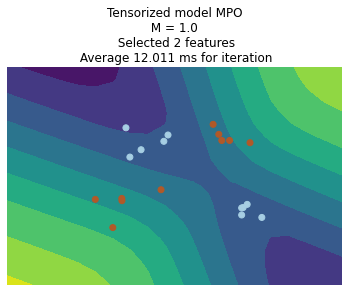

In [31]:
# Plotting code, feel free to ignore.
h = 1.0
x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
y_min, y_max = X[:, 1].min() - 5, X[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# here "model" is your model's prediction (classification) function
Z = mod_tn.predict(np.concatenate((np.c_[xx.ravel(), yy.ravel()], np.zeros((np.c_[xx.ravel(), yy.ravel()].shape[0],extra_feat))), axis = 1))

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

# Plot also the testing points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)
plt.title('Tensorized model MPO\n M = {} \n Selected {} features\n Average {:.3f} ms for iteration'.format(M, num_tn, 1000 * t_tn / epochs))
#plt.savefig('XOR-TN-M=30.png')

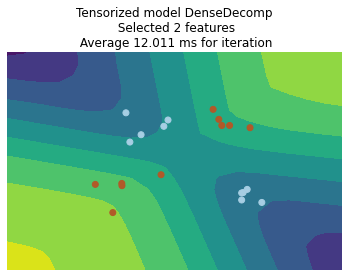

In [40]:
# Plotting code, feel free to ignore.
h = 1.0
x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
y_min, y_max = X[:, 1].min() - 5, X[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# here "model" is your model's prediction (classification) function
Z = mod_tn2.predict(np.concatenate((np.c_[xx.ravel(), yy.ravel()], np.zeros((np.c_[xx.ravel(), yy.ravel()].shape[0],extra_feat))), axis = 1))

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

# Plot also the testing points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)
plt.title('Tensorized model DenseDecomp\n Selected {} features\n Average {:.3f} ms for iteration'.format(num_tn, 1000 * t_tn / epochs))
plt.show()

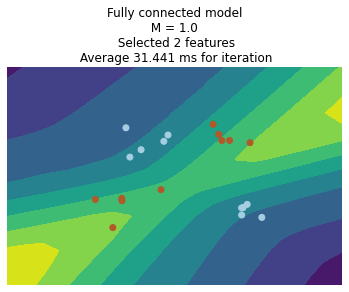

In [33]:
# Plotting code, feel free to ignore.
h = 1.0
x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
y_min, y_max = X[:, 1].min() - 5, X[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# here "model" is your model's prediction (classification) function
Z = mod.predict(np.concatenate((np.c_[xx.ravel(), yy.ravel()], np.zeros((np.c_[xx.ravel(), yy.ravel()].shape[0],extra_feat))), axis = 1))

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)
plt.title('Fully connected model\n M = {} \n Selected {} features\n Average {:.3f} ms for iteration'.format(M, num_fc, 1000 * t_fc / epochs))
#plt.savefig('XOR-M=30.png')

## Optimization on a lambda path

WARNING: before this step the models should be initialized again

In [19]:
path = LassoPath(
    fc_model, 
    n_iters_init=100, 
    patience_init=3, 
    n_iters_path=10, 
    patience_path=2, 
    M=M,
    path_multiplier=1.15,
    lambda_start = 5.0
)

path_tn = LassoPath(
    tn_model, 
    n_iters_init=100, 
    patience_init=3, 
    n_iters_path=10, 
    patience_path=2, 
    M=M,
    path_multiplier=1.15,
    lambda_start = 5.0
)

path_tn2 = LassoPath(
    tn2_model, 
    n_iters_init=100, 
    patience_init=3, 
    n_iters_path=10, 
    patience_path=2, 
    M=M,
    path_multiplier=1.15,
    lambda_start = 5.0
)

In [20]:
path.lassonet.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[],
)

path_tn.lassonet.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[],
)

path_tn2.lassonet.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[],
)

In [21]:
history_fc = path.fit(X_t, y_t, val_dataset = (X_test, y_test), verbose = True)

0it [00:00, ?it/s]

Epoch 1/100
3/3 [==============================] - 0s 43ms/step - loss: 4.6407 - regularization: 2.9033 - number_of_features: 8.0000 - val_loss: 1.9904
Epoch 2/100
3/3 [==============================] - 0s 13ms/step - loss: 2.2659 - regularization: 2.8916 - number_of_features: 8.0000 - val_loss: 1.9353
Epoch 3/100
3/3 [==============================] - 0s 12ms/step - loss: 1.1967 - regularization: 2.8843 - number_of_features: 8.0000 - val_loss: 1.2105
Epoch 4/100
3/3 [==============================] - 0s 12ms/step - loss: 0.8973 - regularization: 2.8771 - number_of_features: 8.0000 - val_loss: 1.1243
Epoch 5/100
3/3 [==============================] - 0s 12ms/step - loss: 0.8466 - regularization: 2.8696 - number_of_features: 8.0000 - val_loss: 0.7833
Epoch 6/100
3/3 [==============================] - 0s 12ms/step - loss: 0.4468 - regularization: 2.8620 - number_of_features: 8.0000 - val_loss: 0.6973
Epoch 7/100
3/3 [==============================] - 0s 12ms/step - loss: 0.4675 - regular

3/3 [==============================] - 0s 12ms/step - loss: 0.0154 - regularization: 0.7304 - number_of_features: 8.0000 - val_loss: 0.0881
Epoch 2/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0198 - regularization: 0.6012 - number_of_features: 8.0000 - val_loss: 0.1116
Epoch 3/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0218 - regularization: 0.4725 - number_of_features: 8.0000 - val_loss: 0.1077
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1124
10.056785937499997
Epoch 1/100
3/3 [==============================] - 0s 21ms/step - loss: 0.0229 - regularization: 0.2465 - number_of_features: 8.0000 - val_loss: 0.1373
Epoch 2/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0243 - regularization: 0.1699 - number_of_features: 8.0000 - val_loss: 0.1088
Epoch 3/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0205 - regularization: 0.1504 - number_of_features: 8.0000 - val_loss: 0.0887
Epo

3/3 [==============================] - 0s 11ms/step - loss: 0.0013 - regularization: 0.1351 - number_of_features: 8.0000 - val_loss: 0.0576
Epoch 3/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0011 - regularization: 0.1347 - number_of_features: 8.0000 - val_loss: 0.0581
Epoch 4/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0011 - regularization: 0.1343 - number_of_features: 8.0000 - val_loss: 0.0557
Epoch 5/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0010 - regularization: 0.1339 - number_of_features: 8.0000 - val_loss: 0.0585
Epoch 6/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0010 - regularization: 0.1335 - number_of_features: 8.0000 - val_loss: 0.0578
Epoch 7/100
3/3 [==============================] - 0s 11ms/step - loss: 8.9811e-04 - regularization: 0.1331 - number_of_features: 8.0000 - val_loss: 0.0545
Epoch 8/100
3/3 [==============================] - 0s 11ms/step - loss: 8.6602e-04 - regularizat

Epoch 4/100
1/1 [==============================] - 0s 0s/step - loss: 0.0472
35.378528822444885
Epoch 1/100
3/3 [==============================] - 0s 11ms/step - loss: 9.8117e-04 - regularization: 0.1138 - number_of_features: 8.0000 - val_loss: 0.0476
Epoch 2/100
3/3 [==============================] - 0s 11ms/step - loss: 5.1659e-04 - regularization: 0.1134 - number_of_features: 8.0000 - val_loss: 0.0465
Epoch 3/100
3/3 [==============================] - 0s 11ms/step - loss: 5.5973e-04 - regularization: 0.1130 - number_of_features: 8.0000 - val_loss: 0.0484
Epoch 4/100
3/3 [==============================] - 0s 10ms/step - loss: 7.5553e-04 - regularization: 0.1126 - number_of_features: 8.0000 - val_loss: 0.0489
Epoch 5/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0012 - regularization: 0.1122 - number_of_features: 8.0000 - val_loss: 0.0445
Epoch 6/100
3/3 [==============================] - 0s 10ms/step - loss: 8.5762e-04 - regularization: 0.1118 - number_of_features

3/3 [==============================] - 0s 18ms/step - loss: 6.3459e-04 - regularization: 0.0876 - number_of_features: 8.0000 - val_loss: 0.0378
Epoch 2/100
3/3 [==============================] - 0s 12ms/step - loss: 6.9035e-04 - regularization: 0.0868 - number_of_features: 8.0000 - val_loss: 0.0385
Epoch 3/100
3/3 [==============================] - 0s 11ms/step - loss: 5.0938e-04 - regularization: 0.0860 - number_of_features: 8.0000 - val_loss: 0.0415
Epoch 4/100
3/3 [==============================] - 0s 10ms/step - loss: 5.5950e-04 - regularization: 0.0852 - number_of_features: 8.0000 - val_loss: 0.0378
Epoch 5/100
3/3 [==============================] - 0s 12ms/step - loss: 5.3513e-04 - regularization: 0.0844 - number_of_features: 8.0000 - val_loss: 0.0394
Epoch 6/100
3/3 [==============================] - 0s 12ms/step - loss: 5.5515e-04 - regularization: 0.0837 - number_of_features: 8.0000 - val_loss: 0.0373
Epoch 7/100
3/3 [==============================] - 0s 10ms/step - loss: 5.77

3/3 [==============================] - 0s 11ms/step - loss: 0.0024 - regularization: 0.0490 - number_of_features: 8.0000 - val_loss: 0.0322
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0284
217.67657419835885
Epoch 1/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0027 - regularization: 0.0472 - number_of_features: 8.0000 - val_loss: 0.0299
Epoch 2/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0020 - regularization: 0.0462 - number_of_features: 8.0000 - val_loss: 0.0324
Epoch 3/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0031 - regularization: 0.0453 - number_of_features: 8.0000 - val_loss: 0.0289
Epoch 4/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0036 - regularization: 0.0443 - number_of_features: 8.0000 - val_loss: 0.0297
Epoch 5/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0032 - regularization: 0.0434 - number_of_features: 8.0000 - val_loss: 0.0307
Epo

3/3 [==============================] - 0s 12ms/step - loss: 0.0255 - regularization: 0.0026 - number_of_features: 3.0000 - val_loss: 0.0332
Epoch 3/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0268 - regularization: 0.0022 - number_of_features: 3.0000 - val_loss: 0.0348
Epoch 4/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0306
579.0240148799653
Epoch 1/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0314 - regularization: 0.0014 - number_of_features: 3.0000 - val_loss: 0.0416
Epoch 2/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0373 - regularization: 0.0011 - number_of_features: 3.0000 - val_loss: 0.0443
Epoch 3/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0353 - regularization: 9.0618e-04 - number_of_features: 2.0000 - val_loss: 0.0371
Epoch 4/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0394 - regularization: 8.5071e-04 - number_of_features: 2.0000 - val_loss: 0.

In [22]:
history_tn = path_tn.fit(X_t, y_t, val_dataset = (X_test, y_test), verbose = True)

0it [00:00, ?it/s]

Epoch 1/100
3/3 [==============================] - 1s 95ms/step - loss: 6.7490 - regularization: 2.8593 - number_of_features: 8.0000 - val_loss: 5.4063
Epoch 2/100
3/3 [==============================] - 0s 9ms/step - loss: 6.3867 - regularization: 2.8500 - number_of_features: 8.0000 - val_loss: 5.1581
Epoch 3/100
3/3 [==============================] - 0s 9ms/step - loss: 6.0424 - regularization: 2.8389 - number_of_features: 8.0000 - val_loss: 4.8823
Epoch 4/100
3/3 [==============================] - 0s 10ms/step - loss: 5.6964 - regularization: 2.8280 - number_of_features: 8.0000 - val_loss: 4.5709
Epoch 5/100
3/3 [==============================] - 0s 10ms/step - loss: 5.2913 - regularization: 2.8169 - number_of_features: 8.0000 - val_loss: 4.2138
Epoch 6/100
3/3 [==============================] - 0s 11ms/step - loss: 4.8521 - regularization: 2.8060 - number_of_features: 8.0000 - val_loss: 3.8122
Epoch 7/100
3/3 [==============================] - 0s 10ms/step - loss: 4.3004 - regulariz

3/3 [==============================] - 0s 9ms/step - loss: 0.0362 - regularization: 2.3072 - number_of_features: 8.0000 - val_loss: 0.0788
Epoch 4/100
1/1 [==============================] - 0s 0s/step - loss: 0.0795
5.75
Epoch 1/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0316 - regularization: 2.1162 - number_of_features: 8.0000 - val_loss: 0.0768
Epoch 2/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0353 - regularization: 2.0134 - number_of_features: 8.0000 - val_loss: 0.0733
Epoch 3/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0364 - regularization: 1.9110 - number_of_features: 8.0000 - val_loss: 0.0735
Epoch 4/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0378 - regularization: 1.8137 - number_of_features: 8.0000 - val_loss: 0.0734
Epoch 5/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0371 - regularization: 1.7410 - number_of_features: 8.0000 - val_loss: 0.0700
Epoch 6/100
3/3 [====

3/3 [==============================] - 0s 10ms/step - loss: 0.0162 - regularization: 0.1437 - number_of_features: 8.0000 - val_loss: 0.0396
Epoch 12/100
1/1 [==============================] - 0s 501us/step - loss: 0.0402
10.056785937499997
Epoch 1/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0155 - regularization: 0.1432 - number_of_features: 8.0000 - val_loss: 0.0390
Epoch 2/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0150 - regularization: 0.1430 - number_of_features: 8.0000 - val_loss: 0.0377
Epoch 3/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0146 - regularization: 0.1427 - number_of_features: 8.0000 - val_loss: 0.0374
Epoch 4/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0143 - regularization: 0.1425 - number_of_features: 8.0000 - val_loss: 0.0375
Epoch 5/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0140 - regularization: 0.1422 - number_of_features: 8.0000 - val_loss: 0.0373
Ep

3/3 [==============================] - 0s 10ms/step - loss: 0.0062 - regularization: 0.1299 - number_of_features: 8.0000 - val_loss: 0.0323
Epoch 6/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0327
23.26195698032047
Epoch 1/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0061 - regularization: 0.1292 - number_of_features: 8.0000 - val_loss: 0.0324
Epoch 2/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0059 - regularization: 0.1288 - number_of_features: 8.0000 - val_loss: 0.0312
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 0.0057 - regularization: 0.1284 - number_of_features: 8.0000 - val_loss: 0.0302
Epoch 4/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0058 - regularization: 0.1280 - number_of_features: 8.0000 - val_loss: 0.0300
Epoch 5/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0056 - regularization: 0.1276 - number_of_features: 8.0000 - val_loss: 0.0302
Epoch 

3/3 [==============================] - 0s 10ms/step - loss: 0.0033 - regularization: 0.1068 - number_of_features: 8.0000 - val_loss: 0.0263
Epoch 7/100
1/1 [==============================] - 0s 449us/step - loss: 0.0261
71.15885823020041
Epoch 1/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0033 - regularization: 0.1057 - number_of_features: 8.0000 - val_loss: 0.0260
Epoch 2/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0033 - regularization: 0.1051 - number_of_features: 8.0000 - val_loss: 0.0261
Epoch 3/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0032 - regularization: 0.1045 - number_of_features: 8.0000 - val_loss: 0.0257
Epoch 4/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0033 - regularization: 0.1040 - number_of_features: 8.0000 - val_loss: 0.0252
Epoch 5/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0032 - regularization: 0.1034 - number_of_features: 8.0000 - val_loss: 0.0256
Epoc

3/3 [==============================] - 0s 8ms/step - loss: 0.0044 - regularization: 0.0659 - number_of_features: 8.0000 - val_loss: 0.0250
Epoch 5/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0258
250.32806032811266
Epoch 1/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0047 - regularization: 0.0636 - number_of_features: 8.0000 - val_loss: 0.0256
Epoch 2/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0050 - regularization: 0.0623 - number_of_features: 8.0000 - val_loss: 0.0253
Epoch 3/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0051 - regularization: 0.0610 - number_of_features: 8.0000 - val_loss: 0.0261
Epoch 4/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0051 - regularization: 0.0597 - number_of_features: 8.0000 - val_loss: 0.0271
Epoch 5/100
1/1 [==============================] - 0s 0s/step - loss: 0.0282
287.8772693773295
Epoch 1/100
3/3 [==============================] - 0s 15ms/st

3/3 [==============================] - 0s 10ms/step - loss: 0.1392 - regularization: 5.3438e-04 - number_of_features: 2.0000 - val_loss: 0.1539
Epoch 4/100
1/1 [==============================] - 0s 0s/step - loss: 0.1564
1164.6241140639247
Epoch 1/100
3/3 [==============================] - 0s 10ms/step - loss: 0.1697 - regularization: 2.8539e-04 - number_of_features: 2.0000 - val_loss: 0.1943
Epoch 2/100
3/3 [==============================] - 0s 10ms/step - loss: 0.2025 - regularization: 1.2847e-04 - number_of_features: 2.0000 - val_loss: 0.2283
Epoch 3/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2394 - regularization: 1.2794e-05 - number_of_features: 1.0000 - val_loss: 0.2500
Epoch 4/100
1/1 [==============================] - 0s 3ms/step - loss: 0.2516


In [23]:
history_tn2 = path_tn2.fit(X_t, y_t, val_dataset = (X_test, y_test), verbose = True)

0it [00:00, ?it/s]

Epoch 1/100
3/3 [==============================] - 1s 73ms/step - loss: 6.1093 - regularization: 3.8726 - number_of_features: 8.0000 - val_loss: 5.3819
Epoch 2/100
3/3 [==============================] - 0s 8ms/step - loss: 3.9521 - regularization: 3.8579 - number_of_features: 8.0000 - val_loss: 2.9271
Epoch 3/100
3/3 [==============================] - 0s 11ms/step - loss: 2.2257 - regularization: 3.8429 - number_of_features: 8.0000 - val_loss: 1.2663
Epoch 4/100
3/3 [==============================] - 0s 10ms/step - loss: 0.7444 - regularization: 3.8301 - number_of_features: 8.0000 - val_loss: 0.4916
Epoch 5/100
3/3 [==============================] - 0s 10ms/step - loss: 0.8670 - regularization: 3.8213 - number_of_features: 8.0000 - val_loss: 0.5786
Epoch 6/100
3/3 [==============================] - 0s 9ms/step - loss: 0.6151 - regularization: 3.8167 - number_of_features: 8.0000 - val_loss: 0.3238
Epoch 7/100
3/3 [==============================] - 0s 9ms/step - loss: 0.3920 - regulariza

3/3 [==============================] - 0s 9ms/step - loss: 0.0225 - regularization: 0.1399 - number_of_features: 8.0000 - val_loss: 0.1432
Epoch 14/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0270 - regularization: 0.1397 - number_of_features: 8.0000 - val_loss: 0.1113
Epoch 15/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0220 - regularization: 0.1395 - number_of_features: 8.0000 - val_loss: 0.0997
Epoch 16/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0266 - regularization: 0.1393 - number_of_features: 8.0000 - val_loss: 0.1140
Epoch 17/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0206 - regularization: 0.1390 - number_of_features: 8.0000 - val_loss: 0.1244
Epoch 18/100
1/1 [==============================] - 0s 0s/step - loss: 0.1050
10.056785937499997
Epoch 1/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0188 - regularization: 0.1385 - number_of_features: 8.0000 - val_loss: 0.1065
Epoc

3/3 [==============================] - 0s 8ms/step - loss: 0.0029 - regularization: 0.1230 - number_of_features: 8.0000 - val_loss: 0.1070
Epoch 5/100
1/1 [==============================] - 0s 11ms/step - loss: 0.1096
26.751250527368537
Epoch 1/100
3/3 [==============================] - 0s 15ms/step - loss: 0.0031 - regularization: 0.1220 - number_of_features: 8.0000 - val_loss: 0.1074
Epoch 2/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0028 - regularization: 0.1215 - number_of_features: 8.0000 - val_loss: 0.1026
Epoch 3/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0026 - regularization: 0.1209 - number_of_features: 8.0000 - val_loss: 0.1061
Epoch 4/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0024 - regularization: 0.1205 - number_of_features: 8.0000 - val_loss: 0.1032
Epoch 5/100
1/1 [==============================] - 0s 11ms/step - loss: 0.1052
30.763938106473816
Epoch 1/100
3/3 [==============================] - 0s 15ms/s

3/3 [==============================] - 0s 8ms/step - loss: 0.0024 - regularization: 0.0957 - number_of_features: 8.0000 - val_loss: 0.0774
Epoch 6/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0034 - regularization: 0.0951 - number_of_features: 8.0000 - val_loss: 0.0872
Epoch 7/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0023 - regularization: 0.0946 - number_of_features: 8.0000 - val_loss: 0.0779
Epoch 8/100
1/1 [==============================] - 0s 0s/step - loss: 0.0886
71.15885823020041
Epoch 1/100
3/3 [==============================] - 0s 19ms/step - loss: 0.0039 - regularization: 0.0935 - number_of_features: 8.0000 - val_loss: 0.0782
Epoch 2/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0033 - regularization: 0.0929 - number_of_features: 8.0000 - val_loss: 0.0806
Epoch 3/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0023 - regularization: 0.0924 - number_of_features: 8.0000 - val_loss: 0.0738
Epoch 4/1

1/1 [==============================] - 0s 16ms/step - loss: 0.0627
143.12588095560707
Epoch 1/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0016 - regularization: 0.0635 - number_of_features: 8.0000 - val_loss: 0.0656
Epoch 2/100
3/3 [==============================] - 0s 1ms/step - loss: 0.0012 - regularization: 0.0627 - number_of_features: 8.0000 - val_loss: 0.0610
Epoch 3/100
3/3 [==============================] - 0s 1ms/step - loss: 0.0011 - regularization: 0.0619 - number_of_features: 8.0000 - val_loss: 0.0650
Epoch 4/100
3/3 [==============================] - 0s 2ms/step - loss: 0.0011 - regularization: 0.0611 - number_of_features: 8.0000 - val_loss: 0.0622
Epoch 5/100
1/1 [==============================] - 0s 0s/step - loss: 0.0632
164.59476309894814
Epoch 1/100
3/3 [==============================] - 0s 14ms/step - loss: 0.0011 - regularization: 0.0595 - number_of_features: 8.0000 - val_loss: 0.0629
Epoch 2/100
3/3 [==============================] - 0s 983us/s

3/3 [==============================] - 0s 9ms/step - loss: 0.0032 - regularization: 0.0233 - number_of_features: 7.0000 - val_loss: 0.0417
Epoch 32/100
3/3 [==============================] - 0s 5ms/step - loss: 0.0024 - regularization: 0.0227 - number_of_features: 7.0000 - val_loss: 0.0445
Epoch 33/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0413
217.67657419835885
Epoch 1/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0026 - regularization: 0.0214 - number_of_features: 7.0000 - val_loss: 0.0407
Epoch 2/100
3/3 [==============================] - 0s 2ms/step - loss: 0.0029 - regularization: 0.0207 - number_of_features: 7.0000 - val_loss: 0.0422
Epoch 3/100
3/3 [==============================] - 0s 2ms/step - loss: 0.0028 - regularization: 0.0201 - number_of_features: 7.0000 - val_loss: 0.0426
Epoch 4/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0424
250.32806032811266
Epoch 1/100
3/3 [==============================] - 0s 15ms

3/3 [==============================] - 0s 2ms/step - loss: 0.0472 - regularization: 3.2717e-04 - number_of_features: 3.0000 - val_loss: 0.0446
Epoch 7/100
3/3 [==============================] - 0s 1ms/step - loss: 0.0510 - regularization: 2.7284e-04 - number_of_features: 3.0000 - val_loss: 0.1421
Epoch 8/100
3/3 [==============================] - 0s 790us/step - loss: 0.0824 - regularization: 2.8502e-04 - number_of_features: 3.5000 - val_loss: 0.0670
Epoch 9/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0579
665.87761711196
Epoch 1/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0700 - regularization: 1.9693e-04 - number_of_features: 2.0000 - val_loss: 0.1027
Epoch 2/100
3/3 [==============================] - 0s 1ms/step - loss: 0.0870 - regularization: 1.6718e-04 - number_of_features: 2.2500 - val_loss: 0.0762
Epoch 3/100
3/3 [==============================] - 0s 2ms/step - loss: 0.0862 - regularization: 1.8021e-04 - number_of_features: 2.5000 - va

## Save the histories

In [12]:
import pickle
with open('history_tn.pickle', 'wb') as handle:
    pickle.dump(history_tn, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('history_fc.pickle', 'wb') as handle:
    pickle.dump(history_fc, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('history_tn2.pickle', 'wb') as handle:
    pickle.dump(history_tn2, handle, protocol=pickle.HIGHEST_PROTOCOL)

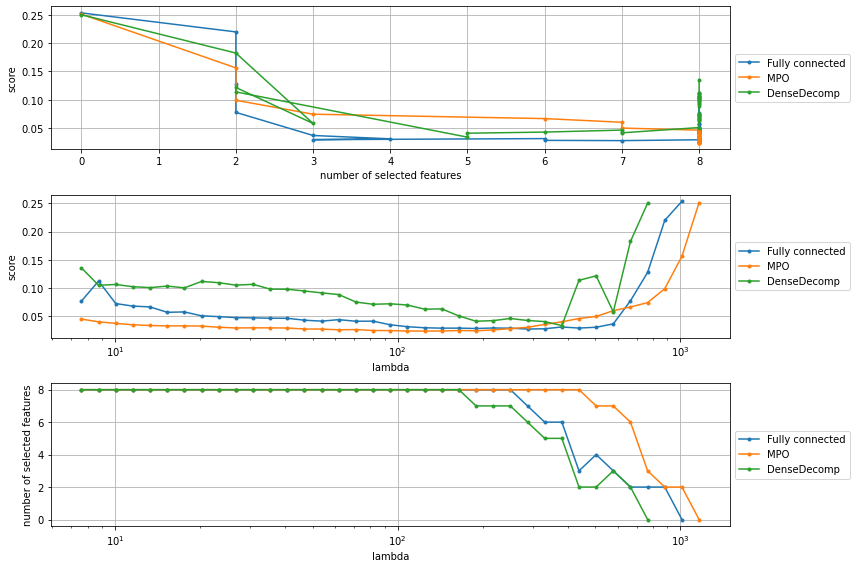

In [25]:
# Plot histories

legend = ['Fully connected', 'MPO', 'DenseDecomp']

title = 'XOR-like function approximation'

plot_history(history_fc[4:], history_tn[4:], history_tn2[4:], figsize = (12, 8), title = title, legend = legend, save = True, savename = 'XOR-history.png')